# Reduce the number of colors of any jpg image

This algorithm presents a straightforward approach to color reduction in images. It's particularly well-suited for images with a distinct variety of colors, where the aim is to simplify the color palette without losing significant visual information. The core of this method relies on the KMeans clustering algorithm, which groups similar colors together and represents them with their centroids. As a result, the image is reconstructed with a reduced color set, making it simpler and highlighting its primary color features.

For images that are more complex or contain a subtle gradation of colors, a more detailed analysis might be required to achieve satisfactory results without compromising the image's integrity. Furthermore, when applying this algorithm to a large set of images or particularly high-resolution images, it's crucial to consider the memory usage and computational efficiency.

In [1]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from skimage.transform import resize
from typing import List, Dict, Tuple

## Load data

In [2]:
def load_image_from_url(img_url:str) -> np.ndarray:
    """
    Loads an image from the specified URL and converts it to an RGB format numpy array.
    
    This function fetches an image from a given URL using the requests library, opens it with PIL (Python Imaging Library),
    converts the image to RGB format to ensure consistency, and then converts it to a numpy array for further processing.
    
    Parameters:
    - img_url (str): The URL of the image to load.
    
    Returns:
    - numpy.ndarray: An array representation of the image in RGB format.
    """
    # Fetch the image from the URL
    response = requests.get(img_url)
    # Open the image using PIL and ensure it is in RGB
    image = Image.open(BytesIO(response.content)).convert('RGB')

    return np.array(image)

In [3]:
# Usage Example:
# Image link
img_url = 'https://fcb-abj-pre.s3.amazonaws.com/img/jugadors/501_maradona.jpg'
# Load data from URL
img_array = load_image_from_url(img_url)

## Number of cluster estimation

In [4]:
def apply_kmeans_clustering(img_array: np.ndarray, n_clusters: int) -> KMeans:
    """
    Applies K-means clustering to group the image pixels into clusters based on their RGB values.
    
    This function uses the KMeans algorithm from sklearn to find clusters in the color space of the image.
    The input image array is reshaped to a 2D array where each row represents a pixel and the columns represent 
    the RGB color values. This is a step towards reducing the number of colors in the image by clustering pixel 
    colors into `n_clusters` clusters.

    Parameters:
    - img_array (numpy.ndarray): The original 3D image array (height, width, channels).
    - n_clusters (int): The number of clusters (colors) to reduce the image to.

    Returns:
    - KMeans: The fitted KMeans object, which includes cluster labels for each pixel in the image.
    """
    # Reshape the image array to a 2D array where each row is a pixel and columns are RGB values
    reshaped_img = img_array.reshape(-1, 3)
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped_img)
    return kmeans

### Elbow method

In [5]:
def perform_elbow_analysis(img_array: np.ndarray, k_range: range) -> List[float]:
    """
    Performs the Elbow analysis to find the optimal number of clusters for K-means clustering.
    
    This function iterates over a range of `k` values, applies K-means clustering for each `k`, and computes the
    Within-Cluster Sum of Squares (WCSS). It then plots these values to help identify the "elbow" point,
    which suggests an optimal number of clusters.
    
    Parameters:
    - img_array (numpy.ndarray): The 2D array of pixels (RGB values) of the image.
    - k_range (range): A range of `k` values to test.
    
    Returns:
    - List[float]: WCSS values for each `k` in `k_range`.
    """
    wcss: List[float] = []
    for k in k_range:
        kmeans = apply_kmeans_clustering(img_array, k)  # Assuming this function is defined elsewhere
        wcss.append(kmeans.inertia_)
    
    # Plotting the Elbow Curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, wcss, '-o', color='black')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('WCSS')
    plt.xticks(list(k_range))
    plt.show()
    
    return wcss

def find_elbow_point(wcss: List[float], k_range: range) -> int:
    """
    Approximates the elbow point using the distance from each point to the line
    formed by the first and last points of the WCSS curve.
    
    Parameters:
    - wcss (List[float]): The list of WCSS values for each k.
    - k_range (range): The range of k values tested.
    
    Returns:
    - int: The approximate k value for the elbow point.
    """
    # Coordinates of the first point
    p1 = (k_range[0], wcss[0])
    # Coordinates of the last point
    p2 = (k_range[-1], wcss[-1])
    
    # Calculate the distances of each point to the line (p1, p2)
    distances = []
    for k, wcss_value in zip(k_range, wcss):
        x0, y0 = k, wcss_value
        x1, y1 = p1
        x2, y2 = p2
        # Calculate the distance from point (x0, y0) to the line (x1, y1) - (x2, y2)
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = ((y2 - y1)**2 + (x2 - x1)**2)**0.5
        distance = numerator / denominator
        distances.append(distance)
    
    # Find the index of the max distance
    elbow_index = distances.index(max(distances))
    return k_range[elbow_index]

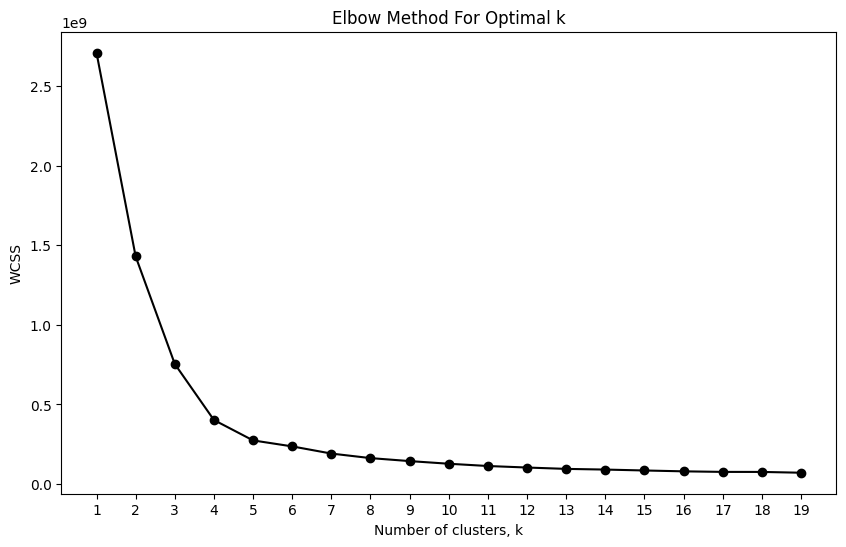

Approximate number of clusters (elbow point): 4


In [6]:
# Usage Example:
# Define the range of k values to test
k_range = range(1, 20)  # Adjust based on your needs
# Perform the elbow analysis
wcss = perform_elbow_analysis(img_array, k_range)
# Find the elbow point
elbow_k = find_elbow_point(wcss, k_range)
print(f"Approximate number of clusters (elbow point): {elbow_k}")

In practice, it is customary to select a range of $k$ values surrounding the estimated elbow point and assess them using additional criteria, such as silhouette scores, to make a more informed decision.

### Silouette method

The computation of the silhouette score can be quite demanding, as it entails determining the distance between each point and all other points within the same cluster, as well as to the nearest cluster. By decreasing the size of the image, you reduce the number of pixels (data points) that need to be analyzed, resulting in quicker computation times.

In [7]:
def resize_image(img_array: np.ndarray, resize_factor: int = 2) -> np.ndarray:
    """
    Resizes an image by a specified factor using skimage, with anti-aliasing enabled to improve
    the quality of the resized image.
    
    Parameters:
    - img_array (numpy.ndarray): The original image array.
    - resize_factor (int): The factor by which the image dimensions will be reduced. 
      For example, a resize_factor of 2 will reduce the image to half its original width and height.
    
    Returns:
    - numpy.ndarray: The resized image array.
    """
    # Calculate the new dimensions
    new_height = img_array.shape[0] // resize_factor
    new_width = img_array.shape[1] // resize_factor
    
    # Resize the image with anti-aliasing
    img_resized = resize(img_array, (new_height, new_width), anti_aliasing=True)
    
    # Convert to uint8 if the original image uses this data type
    if img_array.dtype == np.uint8:
        img_resized = (img_resized * 255).astype(np.uint8)
    
    return img_resized

def calculate_silhouette_scores(img_array: np.ndarray, k_range: range) -> Dict[int, float]:
    """
    Calculates and plots silhouette scores for a range of `k` values to help determine the optimal number of clusters.
    
    This function applies K-means clustering to the image data reshaped to a 2D array of pixels (RGB values) 
    for different numbers of clusters (`k` values) and computes silhouette scores for each. A plot of the 
    silhouette scores across the range of `k` values is generated to aid in selecting the optimal number of clusters.
    
    Parameters:
    - img_array (numpy.ndarray): The original 3D image array (height, width, channels).
    - k_range (range): A range of `k` values for which to calculate silhouette scores.
    
    Returns:
    - dict: A dictionary where keys are `k` values and values are the corresponding silhouette scores.
    """
    silhouette_scores: Dict[int, float] = {}
    for k in k_range:
        if k == 1:
            # Silhouette score cannot be calculated for a single cluster
            continue
        kmeans = apply_kmeans_clustering(img_array, k)
        score = silhouette_score(img_array.reshape(-1, 3), kmeans.labels_)
        silhouette_scores[k] = score
    
    # Plotting the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), '-o', color='black')
    plt.title('Silhouette Scores for Different k Values')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Silhouette Score')
    plt.xticks(list(k_range))
    plt.grid(True)
    plt.show()

    return silhouette_scores

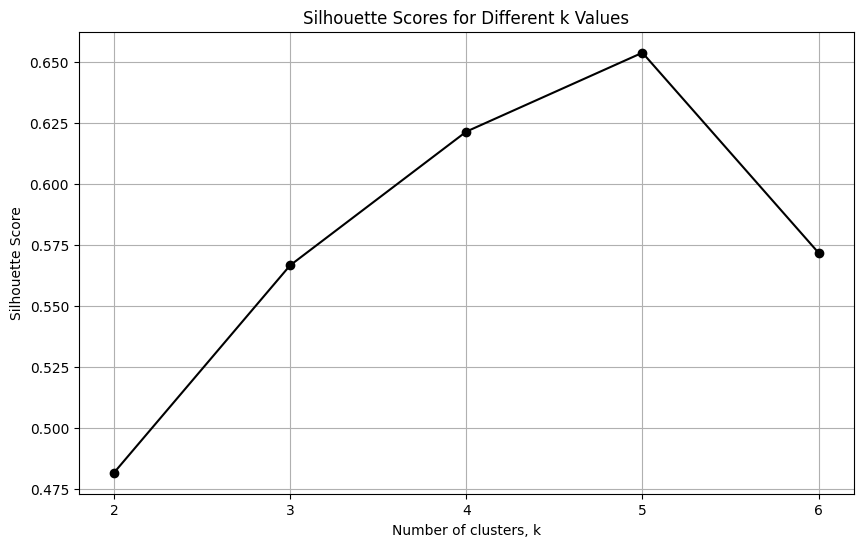

Optimal number of clusters based on silhouette score: 5


In [8]:
# Usage Example:
# Reasize image
img_resize = resize_image(img_array, resize_factor=3)
# Define an interval around the elbow point prediction
epsilon = 2  # Adjust epsilon
start_k = max(elbow_k - epsilon, 2)  # Ensure start_k is at least 2
end_k = elbow_k + epsilon + 1  # Add 1 because the range end is exclusive
k_range = range(start_k, end_k)
# Calculate silhouette scores for the given range of k
silhouette_scores = calculate_silhouette_scores(img_resize, k_range)
# Find the optimal k with the highest silhouette score
silhouette_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"Optimal number of clusters based on silhouette score: {silhouette_k}")


## Image color reduction

In [9]:
def reconstruct_image_from_clusters(centers: np.ndarray, labels: np.ndarray, original_shape: Tuple[int, int, int]) -> np.ndarray:
    """
    Reconstructs the image from the cluster centers and labels.
    
    Parameters:
    - centers (numpy.ndarray): The cluster centers representing the colors in the reduced palette.
    - labels (numpy.ndarray): The labels of each pixel in the flattened image array.
    - original_shape (tuple): The original shape of the image.
    
    Returns:
    - numpy.ndarray: The reconstructed image array.
    """
    # Reconstruct the image array from the centers and labels
    reconstructed_img = centers[labels]
    return reconstructed_img.reshape(original_shape).astype(np.uint8)


def plot_comparison(original_img: np.ndarray, reduced_imgs: List[np.ndarray], titles: List[str], k_values: List[int]) -> None:
    """
    Plots the original image alongside the color-reduced images.
    
    Parameters:
    - original_img (numpy.ndarray): The original image array.
    - reduced_imgs (list of numpy.ndarray): A list of color-reduced image arrays.
    - titles (list of str): Titles for the subplots.
    - k_values (list of int): List containing the optimal k values found by different methods.
    """
    plt.figure(figsize=(15, 10))
    
    # Plot the original image
    plt.subplot(1, len(reduced_imgs) + 1, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot each of the color-reduced images
    for i, (img, title) in enumerate(zip(reduced_imgs, titles), start=2):
        plt.subplot(1, len(reduced_imgs) + 1, i)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    
    # Optionally, add a global footnote if needed
    plt.figtext(0.5, 0.2, f"Elbow Method optimal k: {k_values[0]}, \nSilhouette Method optimal k: {k_values[1]}", ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    plt.show()


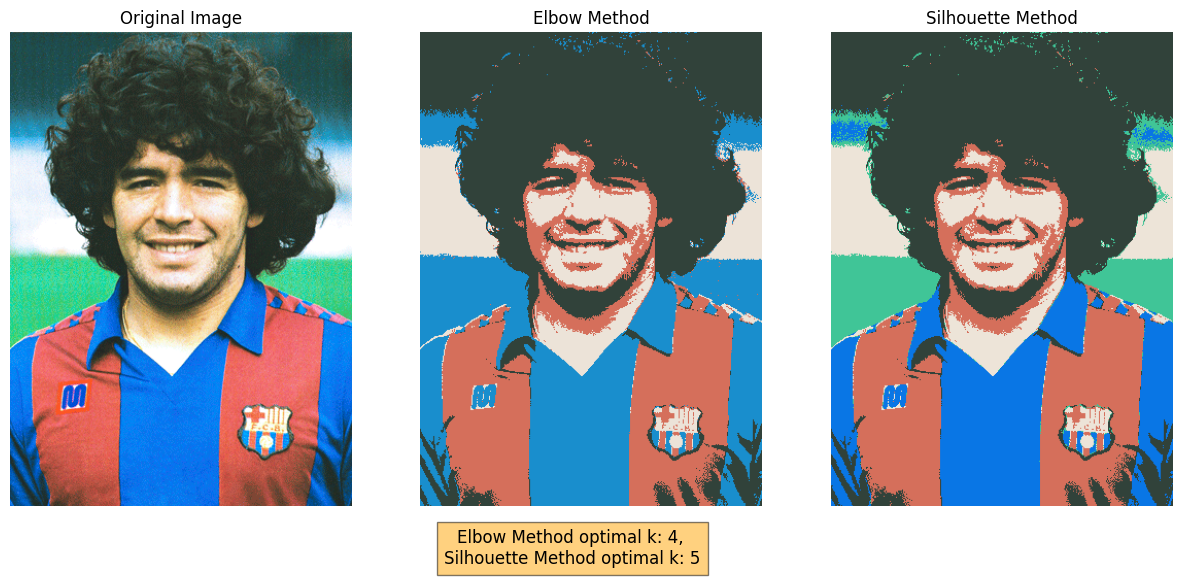

In [10]:
# Usage Example:
# Process and reconstruct the original image for `elbow_k` and `silhouette_k` number of clusters
kmeans_elbow = apply_kmeans_clustering(img_array, elbow_k)
reconstructed_elbow = reconstruct_image_from_clusters(kmeans_elbow.cluster_centers_, kmeans_elbow.labels_, img_array.shape)
kmeans_silhouette = apply_kmeans_clustering(img_array, silhouette_k)
reconstructed_silhouette = reconstruct_image_from_clusters(kmeans_silhouette.cluster_centers_, kmeans_silhouette.labels_, img_array.shape)
# Plot results
plot_comparison(img_array, [reconstructed_elbow, reconstructed_silhouette], 
                ['Elbow Method', 'Silhouette Method'], k_values=[elbow_k, silhouette_k])

**We end up with a reduced color image!**